# $\fbox{1-2}$ 加入者情報レコードの擬似生成

## データ生成に必要な Python ライブラリの準備

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 表示する行の数を設定
pd.options.display.max_rows = 6
# 表示する列の数を設定
pd.options.display.max_columns = 12

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

## コーディングのための知識準備

### shallow copy (参照渡し) と deep copy (値渡し)

In [2]:
a = np.arange(5)
b = a
print('a =', a)
print('b =', b)

a = [0 1 2 3 4]
b = [0 1 2 3 4]


In [3]:
b[3] = 0
print('a =', a)
print('b =', b)

a = [0 1 2 0 4]
b = [0 1 2 0 4]


In [4]:
from copy import deepcopy

a = np.arange(5)
b = deepcopy(a)
print('a =', a)
print('b =', b)

a = [0 1 2 3 4]
b = [0 1 2 3 4]


In [5]:
b[3] = 0
print('a =', a)
print('b =', b)

a = [0 1 2 3 4]
b = [0 1 2 0 4]


In [6]:
df1 = pd.DataFrame(['a', 'b', 'c'])
df2 = df1.copy()
df1 = 0

df2

,0
0,a
1,b
2,c


### 関数を定義する

In [7]:
# "yyyy/mm" 形式の文字列を、時刻 t (スカラー) に変換する。
# yyyy 年 mm 月の月央を t に変換する。
def ym_to_t(ym):
    y = int(ym[:4])
    m = (int(ym[5:]) - 0.5) / 12
    return y + m

In [8]:
print(ym_to_t('2010/06'))

2010.4583333333333


In [9]:
# 時刻 t (スカラー) を "yyyy/mm" 形式の文字列に変換する。
# 時刻 t が yyyy 年 mm 月の1日～月末にあれば、 "yyyy/mm" を返す


def t_to_ym(t):
    y = int(t)
    m = int((t - y) * 12) + 1
    m = max(min(m, 12), 1)
    # 月部分を2桁表示になるよう、つまり
    # "2010/1" でなく "2010/01" となるよう
    # zfill(2) でパディングする。
    return str(y) + '/' + str(m).zfill(2)

In [10]:
print(t_to_ym(2010.49))
print(t_to_ym(2010.5))

2010/06
2010/07


### Python コードの記法について

## 死亡情報以外の擬似生成

In [11]:
df_birth = pd.read_csv('./public_stats/processed/ipss_birth.csv')

df_birth

,year,sex,ratio,cum_ratio
0,1947,F,0.012150,0.012150
1,1948,F,0.012162,0.024311
2,1949,F,0.012288,0.036600
...,...,...,...,...
137,2014,M,0.004812,0.990505
138,2015,M,0.004811,0.995316
139,2016,M,0.004684,1.000000


In [12]:
start_study_t = 2010    # 分析開始時点 (2010年1月)
end_study_t = 2019.999  # 分析終了時点 (2019年12月)

# 指数分布のパラメタ
# 観察開始期間、観察終了期間を決定する。
mu = 10

N = 5000            # N 人の加入者を生成する。
family_ratio = 0.3  # 全体の内、被扶養者の占める割合

In [13]:
# 変数初期化
i = 0
rs = 0              # rs: Random Seed
np.random.seed(rs)  # 乱数シードをセット
df_info = pd.DataFrame()

while len(df_info) < N:
    r = np.random.rand()  # 一様乱数
    rs = rs + 1           # 乱数シード更新
    np.random.seed(rs)
    ss = df_birth[df_birth['cum_ratio'] >= r].iloc[0]  # ss: pd.SerieS
    sex = ss.sex
    by = ss.year  # bs: Birth Year
    # 誕生月を一様に分布させる。
    # Birth Time -> Birth Year Month
    bt = by + np.random.rand()
    rs = rs + 1
    np.random.seed(rs)
    bym = t_to_ym(bt)
    # 擬似データにおいては
    # 観察開始期間、観察終了期間は指数分布で決定する。
    start_t = start_study_t - mu + np.random.exponential(mu)
    rs = rs + 1
    np.random.seed(rs)
    end_t = start_t + np.random.exponential(mu)
    rs = rs + 1
    np.random.seed(rs)
    # | は論理和 (or)
    if (end_t < start_study_t) | (end_study_t < start_t):
        # 分析期間に在籍しない場合 -> 何もしない
        pass
    else:
        # iid: 個人ID
        cols = ['iid', 'sex', 'family', 'birth_ym',
                'start_obs_ym', 'end_obs_ym']
        df_exposure = pd.DataFrame(np.zeros(len(cols)).reshape(1, len(cols)),
                                   columns=cols)
        # 本人: 1, 家族: 2
        family = 2 - (np.random.rand() > family_ratio)
        rs = rs + 1
        np.random.seed(rs)
        df_exposure[cols] = ['i' + str(i).zfill(6), sex, family, bym,
                             t_to_ym(start_t), t_to_ym(end_t)]
        # df_info の下に
        # 新しく作成した１列データフレーム df_exposure を追加する。
        df_info = pd.concat([df_info, df_exposure], axis=0)
    i = i + 1

# index の振り直し
df_info = df_info.reset_index()
# reset_index() により作成されてしまった "index" という列を消す。
del df_info['index']

In [14]:
df_info.shape

(5000, 6)

In [15]:
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym
0,i000000,M,1.0,1952/06,2005/09,2013/09
1,i000001,F,2.0,1972/11,2000/10,2021/06
2,i000002,M,1.0,1978/03,2001/09,2016/09
3,i000003,M,2.0,1989/03,2003/06,2013/12
4,i000006,M,1.0,1973/11,2010/04,2013/09


<IPython.core.display.Javascript object>


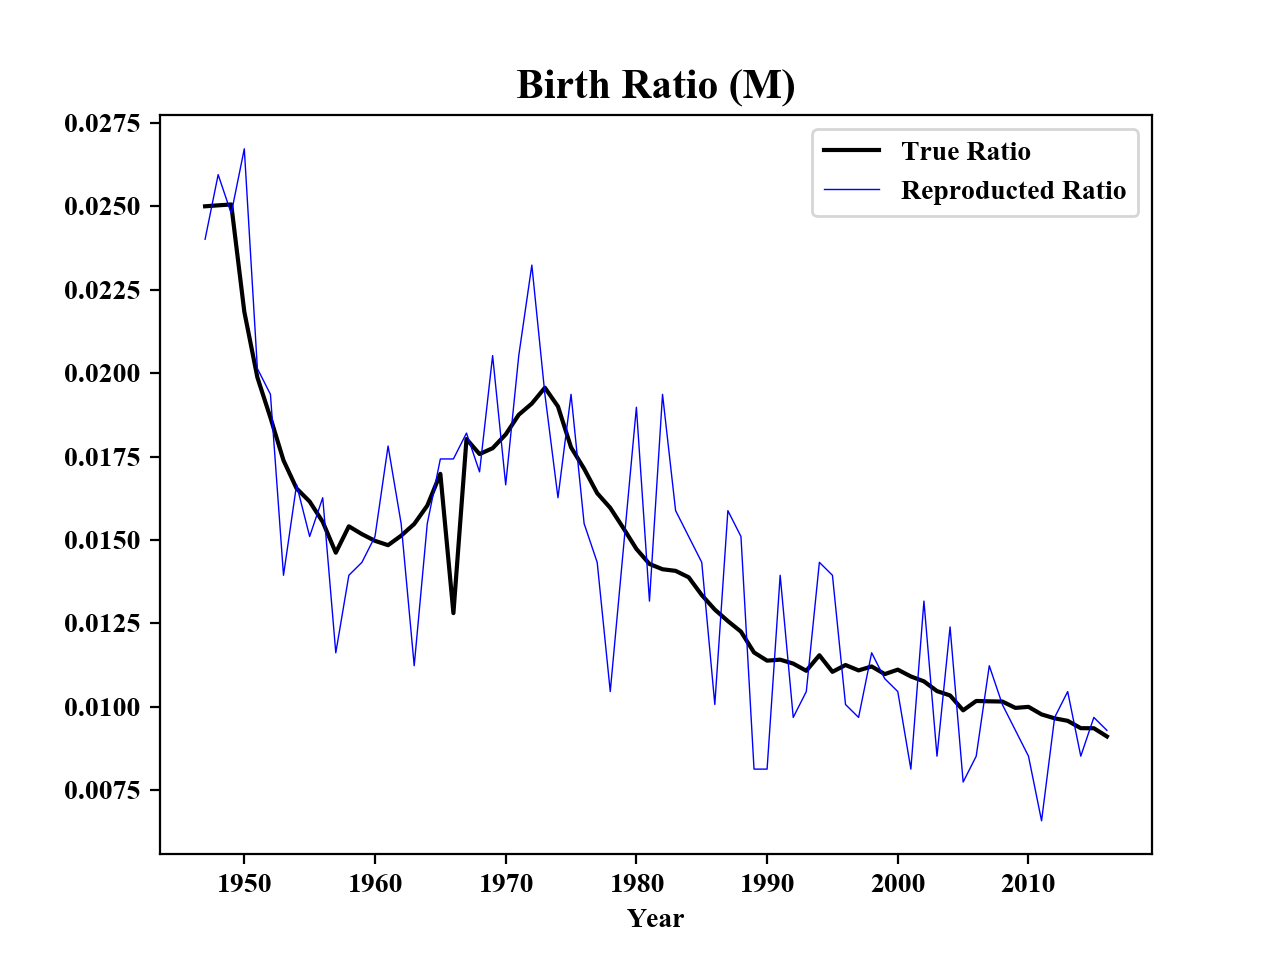

Text(0.5, 1.0, 'Birth Ratio (M)')

In [16]:
# 真の比率 vs. 擬似生成された出生比率（男性のみ）を図で表現

# 真の出生比率
df_birth_M = df_birth.loc[df_birth.sex == 'M', ['year', 'ratio']]
df_birth_M['ratio'] = df_birth_M.ratio / df_birth_M.ratio.sum()

# 擬似生成された加入者の出生比率
df_info_M = df_info.loc[df_info.sex == 'M', ['birth_ym', 'family']]
df_info_M['birth_ym'] = df_info_M.birth_ym.apply(ym_to_t) // 1
df_info_M = df_info_M.groupby(['birth_ym']).count()
df_info_M = df_info_M / df_info_M.sum()
df_info_M

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_birth_M.year, df_birth_M.ratio, c='k', label='True Ratio')
ax.plot(df_info_M.index, df_info_M.family, c='b',
        label='Reproducted Ratio', lw=0.5)
ax.legend(loc='best')
ax.set_xlabel('Year')
ax.set_title('Birth Ratio (M)', fontsize=15)

<IPython.core.display.Javascript object>


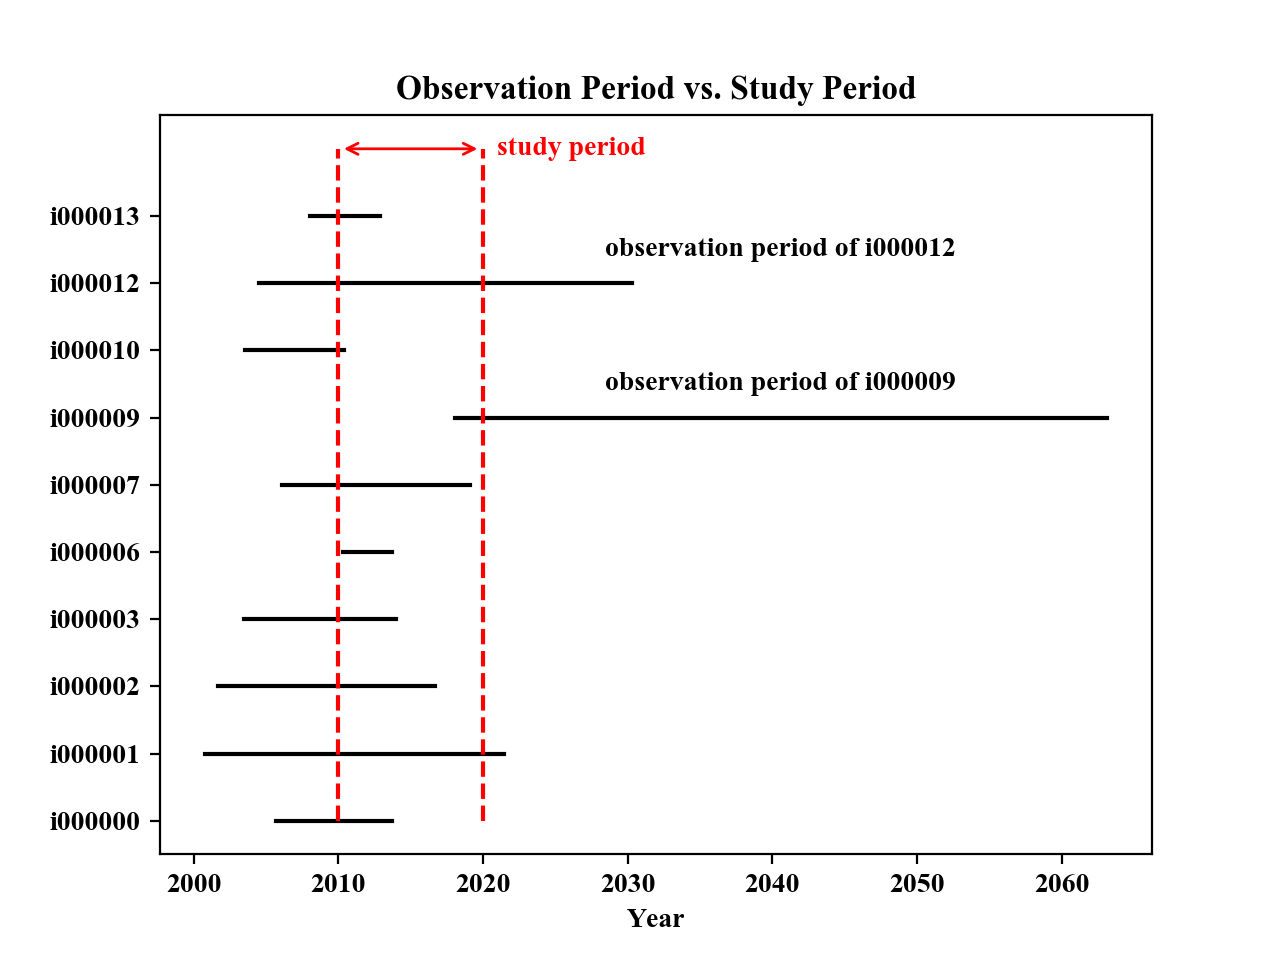

Text(0.5, 1.0, 'Observation Period vs. Study Period')

In [17]:
# 観察期間と分析期間の概念図

df = df_info.iloc[:10].copy()
df['start_obs_t'] = df.start_obs_ym.apply(ym_to_t)
df['end_obs_t'] = df.end_obs_ym.apply(ym_to_t)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in df.index:
    X = df.loc[i, ['start_obs_t', 'end_obs_t']]
    Y = [i, i]
    ax.plot(X, Y, c='k')
ax.plot([start_study_t, start_study_t], [0, 10], c='r', ls='--')
ax.plot([end_study_t, end_study_t], [0, 10], c='r', ls='--')
ax.annotate('', xy=(end_study_t, 10), xytext=(start_study_t, 10),
            arrowprops=dict(arrowstyle='<->', color='r'))
# 分析期間
x = end_study_t + 1
y = 10
t = 'study period'
ax.text(x, y, t, color='r', va='center', ha='left')
# iid = i000009 の観察期間
x = (df.loc[6, 'start_obs_t'] + df.loc[6, 'end_obs_t']) / 2
y = 6.5
t = 'observation period of i000009'
ax.text(x, y, t, color='k', va='center', ha='center')
# iid = i000012 の観察期間
y = 8.5
t = 'observation period of i000012'
ax.text(x, y, t, color='k', va='center', ha='center')

ax.set_yticks(df.index)
ax.set_yticklabels(df.iid)
ax.set_xlabel('Year')
ax.set_title('Observation Period vs. Study Period')

In [18]:
# 観察開始年月の分析開始時点での制限
df_info['start_obs_t'] = df_info['start_obs_ym'].apply(ym_to_t)
#                                               ---------------
#                    時刻が文字列のままでも大小比較は可能ですが、
#                    数値に変換しておくと次の年齢の計算で便利なので数値にすることとします。
more_start_study = (df_info['start_obs_t'] > start_study_t)
df_info['start_obs_t'] = more_start_study * df_info['start_obs_t'] \
    + ~more_start_study * start_study_t
#     -----------------
#     ~ は論理否定演算子、False→True, True→False, 0→1、1→0
df_info['start_obs_ym'] = df_info['start_obs_t'].apply(t_to_ym)

# 観察終了年月の分析終了時点での制限
df_info['end_obs_t'] = df_info['end_obs_ym'].apply(ym_to_t)
less_end_study = (df_info['end_obs_t'] < end_study_t)
df_info['end_obs_t'] = less_end_study * df_info['end_obs_t'] \
    + ~less_end_study * end_study_t
df_info['end_obs_ym'] = df_info['end_obs_t'].apply(t_to_ym)
df_info['birth_t'] = df_info['birth_ym'].apply(ym_to_t)

In [19]:
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,start_obs_t,end_obs_t,birth_t
0,i000000,M,1.0,1952/06,2010/01,2013/09,2010.000000,2013.708333,1952.458333
1,i000001,F,2.0,1972/11,2010/01,2019/12,2010.000000,2019.999000,1972.875000
2,i000002,M,1.0,1978/03,2010/01,2016/09,2010.000000,2016.708333,1978.208333
3,i000003,M,2.0,1989/03,2010/01,2013/12,2010.000000,2013.958333,1989.208333
4,i000006,M,1.0,1973/11,2010/04,2013/09,2010.291667,2013.708333,1973.875000


In [20]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
iid             5000 non-null object
sex             5000 non-null object
family          5000 non-null float64
birth_ym        5000 non-null object
start_obs_ym    5000 non-null object
end_obs_ym      5000 non-null object
start_obs_t     5000 non-null float64
end_obs_t       5000 non-null float64
birth_t         5000 non-null float64
dtypes: float64(4), object(5)
memory usage: 351.6+ KB


In [21]:
types = {'iid': 'str',
         'sex': 'str',
         'family': 'int8',
         'birth_ym': 'str',
         'start_obs_ym': 'str',
         'end_obs_ym': 'str',
         'start_obs_t': 'float32',
         'end_obs_t': 'float32',
         'birth_t': 'float32'}
df_info = df_info.astype(types)

df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
iid             5000 non-null object
sex             5000 non-null object
family          5000 non-null int8
birth_ym        5000 non-null object
start_obs_ym    5000 non-null object
end_obs_ym      5000 non-null object
start_obs_t     5000 non-null float32
end_obs_t       5000 non-null float32
birth_t         5000 non-null float32
dtypes: float32(3), int8(1), object(5)
memory usage: 258.9+ KB


## 死亡情報の擬似生成

### 月次満年齢テーブルの作成

In [22]:
# np.array 形式で、一連の観察期間 "yyyy/mm" を作成。
# npa_pbs_ym: NumPy Array of OBServation Year and Month


def create_npa_obs_ym(start_study_t, end_study_t):
    t = start_study_t
    obs_ym = []
    while t < end_study_t:
        ym = t_to_ym(t)
        obs_ym.append(ym)
        t = ym_to_t(ym) + 1/12
    return np.array(obs_ym)


# 一連の観察期間を時刻 t (スカラー) に変換。
def convert_ym_to_t_in_npa(npa_obs_ym):
    # np.array に apply がないため
    # pd.Series に一度変換して apply して np.array に戻す。
    return np.array(pd.Series(npa_obs_ym).apply(ym_to_t))


npa_obs_ym = create_npa_obs_ym(start_study_t, end_study_t)
npa_obs_t = convert_ym_to_t_in_npa(npa_obs_ym)
npa_birth_t = np.array(df_info['birth_t'])

df_alb_table = df_info.copy()
for i in np.arange(len(npa_obs_ym)):
    # "//" で商(整数)をとる。ちなみに剰余演算子は "%"
    # df_alb_table に新しい列を追加しながら、計算した ALB 列を代入している。
    df_alb_table[npa_obs_ym[i]] = (npa_obs_t[i] - npa_birth_t) // 1
    df_alb_table[npa_obs_ym[i]] = df_alb_table[npa_obs_ym[i]].astype('int8')

In [23]:
df_alb_table.shape

(5000, 129)

In [24]:
df_alb_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,67,67,67,67,67,67
1,i000001,F,2,1972/11,2010/01,2019/12,...,46,46,46,46,47,47
2,i000002,M,1,1978/03,2010/01,2016/09,...,41,41,41,41,41,41
3,i000003,M,2,1989/03,2010/01,2013/12,...,30,30,30,30,30,30
4,i000006,M,1,1973/11,2010/04,2013/09,...,45,45,45,45,46,46


### 月次死亡率テーブルの作成

In [25]:
df_mortality = pd.read_csv('./public_stats/processed/ipss_mortality.csv')

df_mortality

,alb,F,M
0,0,0.000098,0.000097
1,1,0.000020,0.000022
2,2,0.000011,0.000013
...,...,...,...
97,97,0.023992,0.034089
98,98,0.027662,0.038338
99,99,0.031471,0.043682


In [26]:
df_mortality_table = df_alb_table.copy()

# int8 から float64 に変換することで、死亡率がより精緻に取り扱える。
for i in np.arange(len(npa_obs_ym)):
    df_mortality_table[npa_obs_ym[i]] = \
        df_mortality_table[npa_obs_ym[i]].astype('float64')

# (sex, alb) に対応する月次死亡率を取得
def get_mortality(df_mortality, sex, alb):
    if alb < 0 or 100 <= alb:
        return 0
    else:
        return df_mortality.loc[alb, sex]

# df_mortality_table の ym 列に関する月次死亡率を np.array 形式で計算
def calc_monthly_mortality_col(df_mortality, df_alb_table, ym):
    sexes = df_alb_table['sex']  # 加入者の性別一覧
    albs = df_alb_table[ym]      # 加入者の "yyyy/mm" における満年齢一覧
    mortalities = [get_mortality(df_mortality, sex, alb) for (sex, alb)
                   in zip(sexes, albs)]  # リスト内包表記
    # np.isnan の使用と、月次死亡率計算でブロードキャスティングを使うため
    # リスト形式を np.array 形式に変換。
    # ブロードキャスティングについては以下を参照。
    # https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    mortalities = np.array(mortalities)
    mortalities[np.isnan(mortalities)] = 0
    return mortalities


# df_mortality_table に月次死亡率を埋める
for ym in npa_obs_ym:
    mortalities = calc_monthly_mortality_col(df_mortality, df_alb_table, ym)
    df_mortality_table[ym] = mortalities

In [27]:
df_mortality_table.shape

(5000, 129)

In [28]:
df_mortality_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0.001166,0.001166,0.001166,0.001166,0.001166,0.001166
1,i000001,F,2,1972/11,2010/01,2019/12,...,0.000090,0.000090,0.000090,0.000090,0.000099,0.000099
2,i000002,M,1,1978/03,2010/01,2016/09,...,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095
3,i000003,M,2,1989/03,2010/01,2013/12,...,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048
4,i000006,M,1,1973/11,2010/04,2013/09,...,0.000141,0.000141,0.000141,0.000141,0.000157,0.000157


### 月次エクスポージャテーブルの作成

In [29]:
# 通常エクスポージャは [人年] で計算されるが
# ここでは単位を [人月] とする。
df_exposure_table = df_alb_table.copy()
for ym in npa_obs_ym:
    # Boolean values for Start_obs_t
    bs = (df_exposure_table['start_obs_t'] <= ym_to_t(ym))
    # Boolean values for End_obs_t
    be = (ym_to_t(ym) <= df_exposure_table['end_obs_t'])
    # Boolean values for Birth_t
    bb = (df_exposure_table['birth_t'] <= ym_to_t(ym))
    # Boolean values for ALB
    # 健保組合は65歳以上を保障しない
    ba = (df_alb_table[ym] < 65)
    df_exposure_table[ym] = (bs & be & bb & ba) * 1

In [30]:
df_exposure_table.shape

(5000, 129)

In [31]:
df_exposure_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,2019/12,...,1,1,1,1,1,1
2,i000002,M,1,1978/03,2010/01,2016/09,...,0,0,0,0,0,0
3,i000003,M,2,1989/03,2010/01,2013/12,...,0,0,0,0,0,0
4,i000006,M,1,1973/11,2010/04,2013/09,...,0,0,0,0,0,0


### 月次死亡テーブルの作成

In [32]:
rs = 0              # rs: Random Seed
np.random.seed(rs)  # 乱数シードをセット
np.random.random((2, 3))

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411]])

In [33]:
df_death_table = df_alb_table.copy()

rs = 0              # rs: Random Seed
np.random.seed(rs)  # 乱数シードをセット
df_random = np.random.random(df_death_table[npa_obs_ym].shape)
df_death_table[npa_obs_ym] = (df_random < df_mortality_table[npa_obs_ym]) \
    * df_exposure_table[npa_obs_ym] * 1

In [34]:
pd.options.display.max_rows = 20

print(df_death_table.iloc[17].iid, '\n')

df_death_table.loc[17, npa_obs_ym[12:]].head(10)

i000027 



2011/01    0
2011/02    0
2011/03    0
2011/04    1
2011/05    0
2011/06    0
2011/07    0
2011/08    0
2011/09    0
2011/10    0
Name: 17, dtype: object

In [35]:
# cumsum １回適用
df_death_table[npa_obs_ym].cumsum(axis=1).loc[17, npa_obs_ym[12:]].head(10)

2011/01    0
2011/02    0
2011/03    0
2011/04    1
2011/05    1
2011/06    1
2011/07    1
2011/08    1
2011/09    1
2011/10    1
Name: 17, dtype: int64

In [36]:
# cumsum ２回適用
df_death_table[npa_obs_ym].cumsum(axis=1).cumsum(
    axis=1).loc[17, npa_obs_ym[12:]].head(10)

2011/01    0
2011/02    0
2011/03    0
2011/04    1
2011/05    2
2011/06    3
2011/07    4
2011/08    5
2011/09    6
2011/10    7
Name: 17, dtype: int64

In [37]:
# cumsum を２回適用して、１となるセルのみを１とし、それ以外を０とする。
df_death_table[npa_obs_ym] \
    = (df_death_table[npa_obs_ym].cumsum(axis=1).cumsum(axis=1) == 1) * 1

# 整数型に変更してメモリ効率を上げる。
for i in np.arange(len(npa_obs_ym)):
    df_death_table[npa_obs_ym[i]] \
        = df_death_table[npa_obs_ym[i]].astype('int8')

# 死亡後のエクスポージャを０に変更。
before_death_filter = (df_death_table[npa_obs_ym].cumsum(
    axis=1).cumsum(axis=1) <= 1) * 1
df_exposure_table[npa_obs_ym] = df_exposure_table[npa_obs_ym] * \
    before_death_filter

### 死亡情報の加入者情報への付与

In [38]:
# 加入者情報データに死亡情報を追加
df_info['death'] = 0
df_info['death'] = df_info['death'].astype('int8')
df_info.loc[(df_death_table[npa_obs_ym].sum(axis=1) == 1), 'death'] = 1
#           ---------------------------------------------
#                     死亡レコードがある者

# 当月のエクスポージャが 1、翌月のエクスポージャが０の時
# 当月が観察終了年月となる。
# エクスポージャを 1 ヶ月ずらした差分が 1 となる年月が観察最終年月。
df_exp_dif = df_exposure_table[npa_obs_ym] \
    - df_exposure_table[npa_obs_ym].shift(-1, axis=1)
# ただし分析終了年月の翌月は存在しないため None となる。
# 分析終了年月 (2019/12) にエクスポージャが 1 の場合
# 分析終了年月年月が観察終了年月となる。
df_exp_dif[npa_obs_ym[-1]] = df_exposure_table[npa_obs_ym[-1]]
# 差分が -1 の箇所を 0 に変更。
df_exp_dif[df_exp_dif < 0] = 0

In [39]:
exposure_exists = (df_exposure_table[npa_obs_ym].sum(axis=1) > 0)
df_info = df_info[exposure_exists]
df_exposure_table = df_exposure_table[exposure_exists]

In [40]:
b = (df_info['start_obs_ym'] < df_info['birth_ym'])
df_info.loc[b, 'birth_ym'] = df_info.loc[b, 'start_obs_ym']
df_info.loc[b, 'birth_t'] = df_info.loc[b, 'start_obs_t']

In [41]:
# エクスポージャの最終年月を観察終了年月とする。
for i in df_exposure_table.index:
    end_of_exp = (df_exp_dif.loc[i, npa_obs_ym] == 1)
    df_info.loc[i, 'end_obs_ym'] = npa_obs_ym[end_of_exp][0]

# 時刻 t に関する情報を削除し、カラムを並べ替える。
info_cols = ['iid', 'sex', 'family', 'birth_ym',
             'start_obs_ym', 'end_obs_ym', 'death']
df_info = df_info[info_cols]

In [42]:
df_info.shape

(4815, 7)

In [43]:
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death
0,i000000,M,1,1952/06,2010/01,2013/09,0
1,i000001,F,2,1972/11,2010/01,2019/12,0
2,i000002,M,1,1978/03,2010/01,2016/09,0
3,i000003,M,2,1989/03,2010/01,2013/12,0
4,i000006,M,1,1973/11,2010/04,2013/09,0


In [44]:
del df_birth
del df_mortality
del df_exposure
del df_alb_table
del df_mortality_table
del df_exposure_table
del df_death_table

gc.collect()

81

In [45]:
df_info.to_csv('./pseudo_medical/records/excl_bp/info.csv', index=False)

## 一連のプログラムを関数化

In [46]:
import gc

import mylibs.mylib1 as mylib1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(mylib1.ym_to_t('2010/06'))
print(mylib1.t_to_ym(2010.49))
print(mylib1.t_to_ym(2010.5))

2010.4583333333333
2010/06
2010/07


In [47]:
# 引数設定
df_birth = pd.read_csv('./public_stats/processed/ipss_birth.csv')
start_study_t = 2010    # 分析開始時点 (2010年1月)
end_study_t = 2019.999  # 分析終了時点 (2019年12月)
mu = 10
N = 5000            # N 人の加入者を生成する。
family_ratio = 0.3  # 全体の内、被扶養者の占める割合
df_mortality = pd.read_csv('./public_stats/processed/ipss_mortality.csv')

# df_info の作成
df_info = mylib1.create_df_info(df_birth, df_mortality, start_study_t, end_study_t,
                                mu, N, family_ratio)

In [48]:
df_info.shape

(4815, 7)

In [49]:
df_info.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death
0,i000000,M,1,1952/06,2010/01,2013/09,0
1,i000001,F,2,1972/11,2010/01,2019/12,0
2,i000002,M,1,1978/03,2010/01,2016/09,0
3,i000003,M,2,1989/03,2010/01,2013/12,0
4,i000006,M,1,1973/11,2010/04,2013/09,0


## まとめ